<a href="https://colab.research.google.com/github/josehelioaraujo/Grupo51_TechChallenge_Fase3/blob/main/Grupo51_TechChallengeFase3_PreparacaoDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **PosTech Inteligência Artificial Para Desenvolvedores - Fiap**
###  **Projeto Challenge Fase 3 - Grupo 51**

### Objetivo:
- Projeto de **Fine Tuning** de um Modelo Foundation LLM(**Lhama 3.2B**), utilizando o dataset "**The AmazonTitles-1.3MM**".

### Descrição do Arquivo:
  -  Arquivo Colab da Etapa de Preparação de Dados


### **Grupo 51/Alunos:**
  
| Matrícula                       | Nome do Aluno  | Email                                                  |
| ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ |
| RM355027 | José Hélio Araujo Andrade  | helioandrade@hotmail.com|
| RM356210 | Bernardo Guimarães Tinti   | betinti@hotmail.com |


### Arquivos Colab

| Descrição do Arquivo Colab | Link de acesso   |
| ------------------------------------------------------------ |   ------------------------------------------------------------ |
| Colab Principal  | [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1PWEjYtJVAXYlr2zqjj3Ts8r_gW31m_cV#scrollTo=48mnS5Es6O_y) |
| Preparação do Dados(esta página)   | [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QBcfFYk8ij5GZZ8lHKjMhzXUnTgcXUQN#scrollTo=lFz7PZnJBCg) |




In [ ]:
# Instalar bibliotecas necessárias
!pip install datasets
!pip install pandas
#!pip install numpy==1.23.5

import pandas as pd
import os
from multiprocessing import Pool
import os
from datasets import load_dataset
from multiprocessing import Pool, cpu_count
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# Variáveis globais

OUTPUT_FOLDER_PARTS =  '/content/drive/MyDrive/Grupo51_Fiap_Fase3_Challenge/amazon_dataset/parts'
OUTPUT_FOLDER_JSONL =  '/content/drive/MyDrive/Grupo51_Fiap_Fase3_Challenge/amazon_dataset/parts/jsonl'
DATASET_ORIGEM_HUGGINGFACE = 'helioandrade/amazon-titles' # Dataset no Hunggingface

In [ ]:
from google.colab import drive
import os

def montar_google_drive():
    # Montar o Google Drive
    drive.mount('/content/drive')

    # Verificar se a montagem foi bem-sucedida
    if os.path.exists('/content/drive'):
        print("Google Drive montado com sucesso!")

    else:
        print("Falha ao montar o Google Drive. Por favor, verifique as permissões e tente novamente.")

In [ ]:
# Executar a função para montar o Drive
montar_google_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado com sucesso!


In [ ]:
# Listar os arquivos com chunks na pasta jsonl
import os
import re

def sort_key(filename):
    # Extrair o número do nome do arquivo
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

def listar_arquivos_jsonl(dir_path = OUTPUT_FOLDER_JSONL):
    if not os.path.exists(dir_path):
        print(f"O diretório {dir_path} não existe.")
        return

    try:
        files = os.listdir(dir_path)
    except PermissionError:
        print(f"Sem permissão para acessar o diretório {dir_path}.")
        return

    if not files:
        print(f"O diretório {dir_path} está vazio.")
        return

    # Ordenar os arquivos numericamente
    sorted_files = sorted(files, key=sort_key)

    print(f"Arquivos encontrados em {dir_path}:")
    for file in sorted_files:
        print(file)

    print(f"\nTotal de arquivos: {len(files)}")


In [ ]:
def summarize_dataset(df):
    total_records = len(df)
    file_size = df.memory_usage(deep=True).sum()  # Tamanho do DataFrame em bytes
    null_title = df['title'].isna().sum()
    null_content = df['content'].isna().sum()
    empty_title = (df['title'] == '').sum()
    empty_content = (df['content'] == '').sum()

    print('----------------------------------------------------------')
    print(f"Resumo do Dataset:")
    print('----------------------------------------------------------')
    print(f"Total de registros......: {total_records}")
    print(f"Tamanho arquivo.........: {file_size / (1024 ** 2):.2f} MB")  # Convertendo para MB
    print(f"Qtde com 'title' nulo...: {null_title}")
    print(f"Qtde com 'content' nulo.: {null_content}")
    print(f"Qtde com 'title' vazio..: {empty_title}")
    print(f"Qtde com 'content' vazio: {empty_content}")
    print('----------------------------------------------------------')

In [ ]:
def Obter_nome_arquivo_chunk(indice):
    formatted_index = f"{indice:03d}"
    file_name = f"{OUTPUT_FOLDER_JSONL}/AMAZON-CHUNK_{formatted_index}.jsonl"

    return file_name

In [ ]:
def Obter_nome_arquivo_json(indice):
    formatted_index = f"{indice:03d}"
    file_name = f"AMAZON-TITLES-JSONL_{formatted_index}.jsonl"
    return file_name

In [ ]:
import os
import json
import itertools
import math
from datasets import load_dataset
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def processar_chunk(chunk, output_folder, file_index):

    arquivo_saida = f'Amazon_chunk_{file_index:03d}.jsonl'

    caminho_completo = os.path.join(output_folder, arquivo_saida)

    contents_json = []
    for item in chunk:
        if item.get('title') and item.get('content'):
            selected_fields = {
                'uid': item.get('uid'),
                'title': item.get('title'),
                'content': item.get('content')
            }
            contents_json.append(json.dumps(selected_fields, ensure_ascii=False))

    with open(caminho_completo, 'w', encoding='utf-8') as f:
        for content in contents_json:
            f.write(content + '\n')

    return arquivo_saida, len(contents_json)

In [ ]:
# Preparação dos dados, usando paralelismo no 'chunk' do dataset de origim

import os
import json
from datasets import load_dataset
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import itertools
import math

def preparar_dados_com_paralelismo(dataset_origem, total_records, chunk_size):

    output_folder = '/content/drive/MyDrive/Grupo51_Fiap_Fase3_Challenge/amazon_dataset/parts'
    output_folder_jsonl = os.path.join(output_folder, 'jsonl')

    num_chunks = math.ceil(total_records / chunk_size)

    # Criar pastas de saída se não existirem
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(output_folder_jsonl, exist_ok=True)

    # Diretório para armazenar o cache
    cache_directory = './cache'

    print(f'Carregando o dataset {dataset_origem} em modo de streaming com cache e paralelismo')

    dataset = load_dataset(
        dataset_origem,
        split='train',
        streaming=True,
        cache_dir=cache_directory  )

    total_registros =obter_tamanho_dataset(dataset_origem)
    print(f"Total de registros no dataset: {total_registros}")

    print(f'Total de registros a processar: {total_records}')
    print(f'Tamanho do chunk: {chunk_size}')

    # Iterador do dataset
    dataset_iter = iter(dataset)

  # Processamento dos chunks com paralelismo

    with ProcessPoolExecutor() as executor:
        futures = []
        for i in range(num_chunks):
            # Para o último chunk, pegamos os registros restantes
            if i == num_chunks - 1:
                chunk = list(itertools.islice(dataset_iter, total_records % chunk_size or chunk_size))
            else:
                chunk = list(itertools.islice(dataset_iter, chunk_size))

            if not chunk:  # Se não houver mais dados, sair do loop
                break
            future = executor.submit(processar_chunk, chunk, output_folder_jsonl, i+1)
            futures.append(future)

        # Acompanhamento do progresso
        total_processado = 0
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processando chunks"):
            arquivo_salvo, registros_processados = future.result()
            total_processado += registros_processados
            print(f'Arquivo {arquivo_salvo} salvo com sucesso. Contém {registros_processados} registros.')

    print(f"Processamento concluído. Total de registros processados: {total_processado}")

In [ ]:
def obter_tamanho_dataset(nome_dataset):
     dataset = load_dataset(
        nome_dataset,
        split='train')

     df = dataset.to_pandas()
     total_registros = len(df)
     print(f'O dataset {nome_dataset} contém {total_registros} registros')

     summarize_dataset(df)
     return total_registros

In [ ]:
####################################################################################
# Etapa - Preparação dos dados
 ###################################################################################

analisar_dataset(DATASET_ORIGEM_HUGGINGFACE)

total_registros=1000
Tamanho_chunk=  100000

print(f'Preparando dos dados, usando {total_registros} do dataset de origem com tamanho do chunk {Tamanho_chunk} registros')

preparar_dados_com_paralelismo(DATASET_ORIGEM_HUGGINGFACE,total_registros,Tamanho_chunk)

print('---------------------------------------------------')
print('Exibição da lista dos arquivos de chunks gerados')
print('---------------------------------------------------')

listar_arquivos_jsonl()

O dataset helioandrade/amazon-titles contém 2248619 registros
----------------------------------------------------------
Resumo do Dataset:
----------------------------------------------------------
Total de registros......: 2248619
Tamanho arquivo.........: 1911.46 MB
Qtde com 'title' nulo...: 0
Qtde com 'content' nulo.: 0
Qtde com 'title' vazio..: 126834
Qtde com 'content' vazio: 749901
----------------------------------------------------------
O dataset 'helioandrade/amazon-titles' possui 2248619 registros.
Insights:
- O dataset contém uma grande quantidade de registros.
- É importante verificar a presença de valores nulos ou vazios em 'title' e 'content', pois podem impactar a qualidade dos dados.
- É possível analisar a distribuição de tamanhos de títulos e conteúdos para entender a diversidade e complexidade do dataset.
- A análise de palavras-chave frequentes pode revelar temas e tópicos relevantes no dataset.
- Esses insights podem auxiliar na preparação e tratamento dos dados 

Processando chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Arquivo Amazon_chunk_003.jsonl salvo com sucesso. Contém 178 registros.
Arquivo Amazon_chunk_004.jsonl salvo com sucesso. Contém 143 registros.
Arquivo Amazon_chunk_002.jsonl salvo com sucesso. Contém 111 registros.
Arquivo Amazon_chunk_001.jsonl salvo com sucesso. Contém 98 registros.
Arquivo Amazon_chunk_005.jsonl salvo com sucesso. Contém 155 registros.


Processando chunks: 100%|██████████| 5/5 [00:00<00:00, 116.75it/s]


Processamento concluído. Total de registros processados: 685
---------------------------------------------------
Exibição da lista dos arquivos de chunks gerados
---------------------------------------------------
Arquivos encontrados em /content/drive/MyDrive/Grupo51_Fiap_Fase3_Challenge/amazon_dataset/parts/jsonl:
Amazon_chunk_001.jsonl
Amazon_chunk_002.jsonl
Amazon_chunk_003.jsonl
Amazon_chunk_004.jsonl
Amazon_chunk_005.jsonl

Total de arquivos: 5




# Etapas da Preparação de Dados

### 1. Carregamento do Dataset:

- O código utiliza a biblioteca `datasets` para carregar o dataset 'helioandrade/amazon-titles' em modo de streaming.
 - O modo de streaming permite processar o dataset em partes, evitando sobrecarga de memória, especialmente com datasets grandes.
- O carregamento do dataset é feito com caching para acelerar o acesso aos dados em execuções subsequentes.
 - O código também utiliza paralelismo para acelerar o carregamento e processamento dos dados.

### 2. Processamento do Dataset em Chunks:

 - O dataset é dividido em 'chunks' de tamanho definido (100000 no exemplo) para facilitar o processamento em partes.
- Cada 'chunk' é processado individualmente, permitindo análise e tratamento mais eficiente.
 - O código salva cada 'chunk' em um arquivo JSONL (JSON Lines) para posterior análise ou uso.


### 3. Logging do Processamento:

 - O código registra informações relevantes sobre o processamento, como:
   - O nome do arquivo salvo
   - A quantidade de registros em cada 'chunk'
  - O progresso do processamento em geral
  - Essa informação é importante para monitorar o andamento e identificar possíveis problemas durante o processamento.


### 4. Conclusões:

 - O dataset 'helioandrade/amazon-titles' contém uma grande quantidade de registros (2248619).
 - O dataset tem um tamanho considerável (1911.46 MB).
 - Existem registros com títulos ou conteúdos nulos ou vazios, que podem impactar a qualidade dos dados.
 - Essas informações podem ajudar na preparação e tratamento dos dados para tarefas como treinamento de modelos de linguagem.

### Pontos de Melhoria:

 - Implementar tratamento de erros mais robusto para lidar com problemas de processamento (ex: erros de conexão, falhas de escrita em disco).
 - Melhorar a organização e legibilidade do código com a utilização de funções e classes para modularizar o processamento.
 - Investigar o uso de bibliotecas como 'dask' para processamento distribuído em cluster, escalando o processamento para datasets ainda maiores.
 - Implementar métricas para avaliar a qualidade dos dados e identificar possíveis vieses.
 - Avaliar estratégias de compressão para reduzir o tamanho dos arquivos JSONL gerados.
 - Considerar a utilização de bancos de dados para armazenar os dados processados, facilitando o acesso e análise.



## Preparandos os Dados

Foram realizados os seguintes tarefas:


- Leitura do dataset de origem do HuggingFace(trn.json)
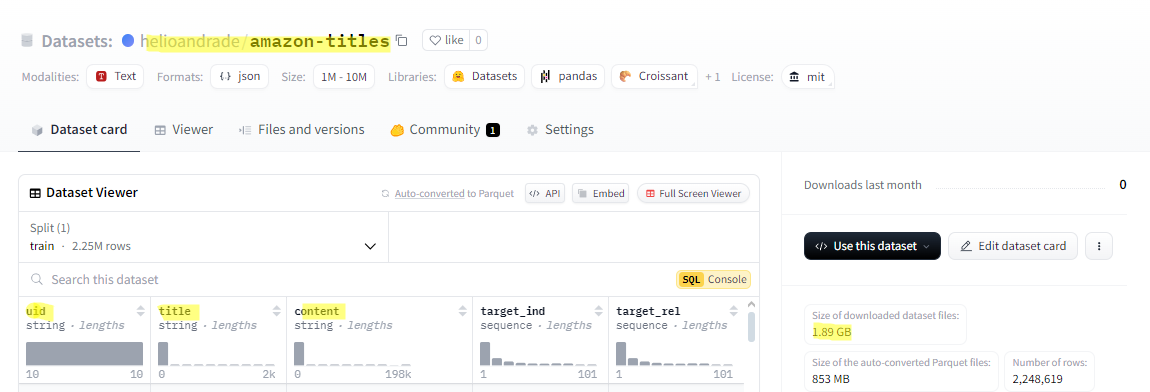

- Divisão do dataset de orirem, em vários arquivos 'chunks', devido ao tamanho muito grande do arquivo hson, visando melhorar a performance e otimizar recursos computacionais no Google Colab, quando da realização  da tempo de leitura do mesmo
- Limpeza os registros, quando os campos 'title' e 'content', forem nulos

- Salvamento arquivos 'chunks numa pasta local do Google Drive
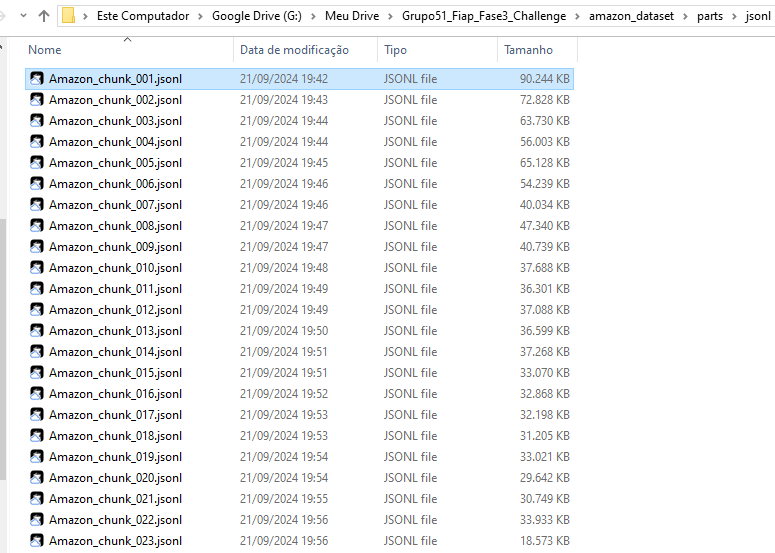

- Realização do upload dos arquivos de chunks em um repositório do HuggingFace, que posteriorment, serão usados na etapa de fine tuning do modelo selecionado e criação de perguntas/resposta do chatbot conversacional.
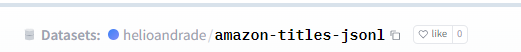
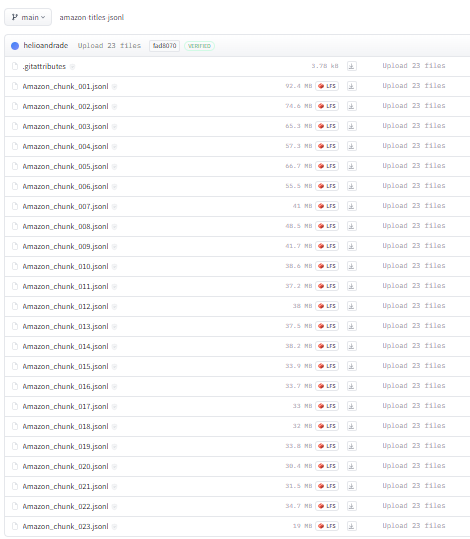

- Realização de upload dos arquivos de perguntas e respostas que foram gerados pelo processo de fine-tuning(salvos em pasta local do Google Drive), e que serão utilizados na inferência do modelo treinado
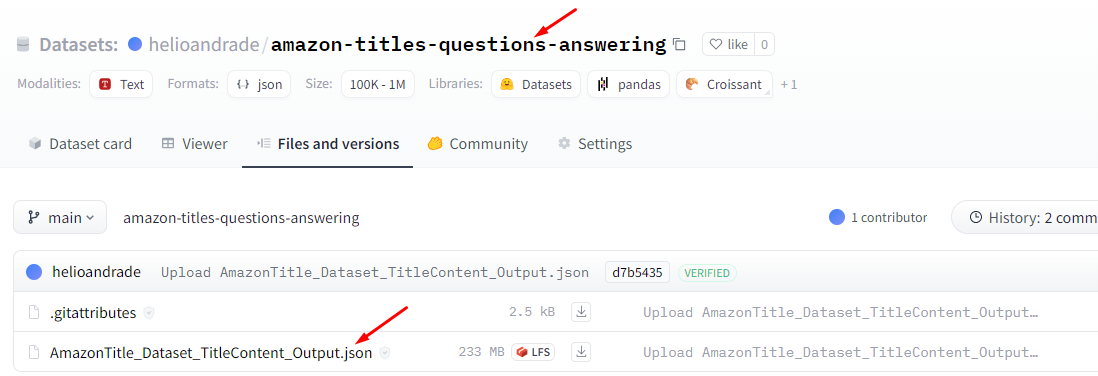

- Amostra do Arquivo Json com perguntas e respostas
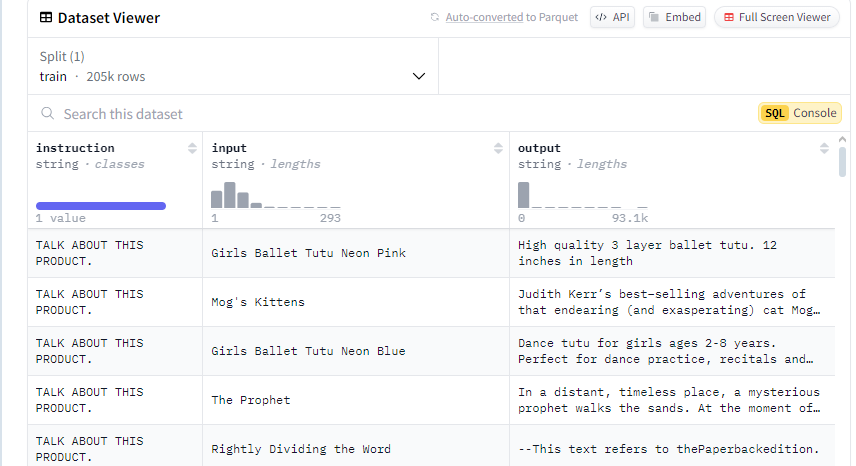


## Log do processamento do 'chunk' do dataset de origem
- O dataset helioandrade/amazon-titles contém 2248619 registros

- Carregando o dataset helioandrade/amazon-titles em modo de streaming com cache e paralelismo

- O dataset helioandrade/amazon-titles contém 2248619 registros

- Total de registros no dataset: 2248619
- Total de registros a processar: 2248619
- Tamanho do chunk: 100000

- Arquivo Amazon_chunk_020.jsonl salvo com sucesso. Contém 48350 registros.

- Arquivo Amazon_chunk_012.jsonl salvo com sucesso. Contém 67544 registros.

- Arquivo Amazon_chunk_010.jsonl salvo com sucesso. Contém 70086 registros.

- Arquivo Amazon_chunk_013.jsonl salvo com sucesso. Contém 66686 registros.

- Arquivo Amazon_chunk_022.jsonl salvo com sucesso. Contém 49513 registros.

- Arquivo Amazon_chunk_014.jsonl salvo com sucesso. Contém 65521 registros.

- Arquivo Amazon_chunk_006.jsonl salvo com sucesso. Contém 59384 registros.

- Arquivo Amazon_chunk_004.jsonl salvo com sucesso. Contém 56812 registros.

- Arquivo Amazon_chunk_003.jsonl salvo com sucesso. Contém 63146 registros.

- Arquivo Amazon_chunk_017.jsonl salvo com sucesso. Contém 56435 registros.

- Arquivo Amazon_chunk_016.jsonl salvo com sucesso. Contém 57886 registros.

- Arquivo Amazon_chunk_018.jsonl salvo com sucesso. Contém 52546 registros.

- Arquivo Amazon_chunk_007.jsonl salvo com sucesso. Contém 62677 registros.

- Arquivo Amazon_chunk_001.jsonl salvo com sucesso. Contém 75062 registros.

- Arquivo Amazon_chunk_011.jsonl salvo com sucesso. Contém 68141 registros.

- Arquivo Amazon_chunk_008.jsonl salvo com sucesso. Contém 81979 registros.

- Arquivo Amazon_chunk_002.jsonl salvo com sucesso. Contém 66806 registros.

- Arquivo Amazon_chunk_005.jsonl salvo com sucesso. Contém 64526 registros.

- Arquivo Amazon_chunk_009.jsonl salvo com sucesso. Contém 72976 registros.

- Arquivo Amazon_chunk_015.jsonl salvo com sucesso. Contém 58788 registros.

- Arquivo Amazon_chunk_021.jsonl salvo com sucesso. Contém 47118 registros.

- Arquivo Amazon_chunk_019.jsonl salvo com sucesso. Contém 53425 registros.

- Processando chunks: 100%|██████████| 23/23 [00:01<00:00, 20.67it/s]Arquivo Amazon_chunk_023.jsonl salvo com sucesso. Contém 24996 registros.

- Processamento concluído. Total de registros processados: 1390403

## **Referências**

### Repositórios no HuggingFace

 - Dataset de origem(trn.json)
  
    https://huggingface.co/datasets/helioandrade/amazon-titles

- Arquivos 'Chunks' do dataset de origem

   https://huggingface.co/datasets/helioandrade/amazon-titles-jsonl/tree/main


# **Conclusões**

O dataset helioandrade/amazon-titles/trn.json contém 2248619 registros

**Resumo do Dataset:**

- Total de registros............: 2248619
- Tamanho arquivo.............: 1911.46 MB
- Qtde com 'title' nulo.........: 0
- Qtde com 'content' nulo...: 0
- Qtde com 'title' vazio.........: 126834
- Qtde com 'content' vazio..;: 749901


### **Insights Obtidos**:

- O dataset contém uma grande quantidade de registros.
- É importante verificar a presença de valores nulos ou vazios em 'title' e 'content', pois podem impactar a qualidade dos dados.
- É possível analisar a distribuição de tamanhos de títulos e conteúdos para entender a diversidade e complexidade do dataset.
- A análise de palavras-chave frequentes pode revelar temas e tópicos relevantes no dataset.
- Esses insights podem auxiliar na preparação e tratamento dos dados para tarefas como treinamento de modelos de linguagem.